# Preprocessing

In [20]:
import os
import json
import csv
import pprint
pp = pprint.PrettyPrinter(indent=4)

In [5]:
# Specify the directory path
directory_path = 'data/agent/'

agent_list = []
agent_id = 0

# List all files in the directory
for filename in os.listdir(directory_path):
    # Join the file name with the directory path to get the full file path
    full_file_path = os.path.join(directory_path, filename)

    # Check if it's a file and not a directory
    if os.path.isfile(full_file_path):
        # print(filename)
        tokens = filename.split('_')
        mode = tokens[0]
        agent_num = int(tokens[1])
        kill = float(tokens[2])
        time = float(tokens[3])
        idx = int(tokens[4].split(".")[0][-1])
        features = []

        with open(full_file_path, newline='', encoding='utf-8') as csvfile:
            # Create a CSV reader object
            csv_reader = csv.reader(csvfile)
        
            # Read the header (if any)
            header = next(csv_reader)
        
            # Iterate over the rows in the CSV file
            for row in csv_reader:
                parsed = [int(item) for item in row]
                features.append(parsed)

        agent = {
            'id': agent_id,
            'mode': mode,
            'agent_num': agent_num,
            'kill': kill,
            'time': time,
            'idx': idx,
            'features': features
        }
        agent_list.append(agent)
        agent_id += 1
        # print(mode, agent_num, kill, time, idx, len(features))

print(len(agent_list))

72


In [6]:
pp.pprint(agent_list[0])

{   'agent_num': 2,
    'features': [   [0, 1, 0, 0, 0],
                    [0, 1, 0, 0, 0],
                    [0, 1, 0, 0, 0],
                    [0, 0, 1, 0, 0],
                    [1, 0, 0, 0, 0],
                    [1, 0, 0, 1, 0],
                    [1, 0, 0, 0, 0],
                    [1, 0, 0, 0, 0],
                    [1, 0, 0, 0, 0],
                    [0, 1, 0, 0, 0],
                    [1, 0, 0, 0, 0],
                    [0, 0, 1, 0, 0],
                    [0, 1, 0, 0, 0],
                    [1, 0, 0, 0, 0],
                    [1, 0, 0, 0, 0],
                    [1, 0, 0, 0, 0],
                    [0, 0, 1, 0, 0],
                    [1, 0, 0, 0, 0],
                    [0, 0, 1, 0, 0],
                    [1, 0, 0, 0, 0],
                    [1, 0, 0, 0, 0],
                    [0, 1, 0, 0, 0],
                    [0, 1, 0, 0, 0],
                    [1, 0, 0, 0, 0],
                    [1, 0, 0, 0, 0],
                    [0, 0, 1, 0, 0],
                  

In [7]:
agent_dict = {}
for agent in agent_list:
    a_id = agent['id']
    features = agent['features']
    agent_dict[a_id] = features
print(len(agent_dict))

72


In [8]:
print(len(agent_dict)) # Number of Agents
for key, val in agent_dict.items():
    print(len(val)) # Number of Actions for an agent
    print(len(val[0])) # Number of feature dimensions for an action
    print(val[0][0]) # A feature value
    break

72
174
5
0


# Torch

In [9]:
# CUDA Availability
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

C:\Users\user\Anaconda3\envs\marl\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\user\Anaconda3\envs\marl\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\user\Anaconda3\envs\marl\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:\n%s" %


cuda


In [10]:
agent_count = len(agent_dict)
max_seq_len = -1

tup_list = []
for mover_id, val in agent_dict.items():
    curr_seq_len = len(val)
    if max_seq_len < curr_seq_len:
        max_seq_len = curr_seq_len
    tup = (mover_id, curr_seq_len)
    tup_list.append(tup)

tup_list.sort(key=lambda x: x[1], reverse=True)

In [11]:
print(tup_list[-1])
print(tup_list[0])

(63, 1)
(53, 10000)


In [12]:
import math
import random
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
from torch.nn.utils.rnn import pack_padded_sequence
from torch.nn.utils.rnn import pad_packed_sequence
from torch import optim
from importlib import reload
import seq2seq as ss
reload(ss)

input_size = 5
output_size = 5
hidden_size = 32
mini_batch = 4
learning_rate=0.01

encoder = ss.EncoderMSE(input_size, hidden_size).to(device)
decoder = ss.DecoderMSE(input_size, hidden_size, output_size).to(device)
encoder_optimizer = optim.AdamW(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.AdamW(decoder.parameters(), lr=learning_rate)

criterion = nn.MSELoss()

In [13]:
packed_inputs = []
packed_inputs_d = []
batch_sizes = []
seq_sums = []

batch_count = math.ceil(agent_count / mini_batch)
for i in range(batch_count):
    batch_list = []
    seq_len = []
    seq_sum = 0
    for j in range(mini_batch):
        curr_idx = i * mini_batch + j
        if curr_idx < agent_count:
            m_id = tup_list[curr_idx][0]
            m_seq = agent_dict[m_id]
            m_tensor = torch.tensor(m_seq, dtype=torch.float, device=device)
            batch_list.append(m_tensor)
            seq_len.append(len(m_seq))
            seq_sum += len(m_seq)
            # print(m_tensor.shape)
    # print(seq_len)
    padded = pad_sequence(batch_list, batch_first=True)
    packed = pack_padded_sequence(padded, seq_len, batch_first=True)
    packed_inputs.append(packed)
    batch_sizes.append(len(seq_len))
    
    d_batch_list = []
    for t in batch_list:
        a = torch.zeros(1, input_size, device=device)
        b = t[:-1, :]
        c = torch.cat((a, b), 0)
        d_batch_list.append(c)
    padded = pad_sequence(d_batch_list, batch_first=True)
    packed = pack_padded_sequence(padded, seq_len, batch_first=True)
    packed_inputs_d.append(packed)
    seq_sums.append(seq_sum)
    
print(len(packed_inputs))
print(len(batch_sizes))
print(len(packed_inputs_d))
print(len(seq_sums))

18
18
18
18


In [14]:
import time

losses = []
epoch = 50

start_time = time.time()

# Minibatch iteration
for ep in range(epoch):
    
    indexes = list(range(len(packed_inputs)))
    random.shuffle(indexes)

    counter = 0
    ep_loss = 0
    for idx in indexes:

        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()
        loss = 0

        encoder_input = packed_inputs[idx]
        batch_size = batch_sizes[idx]
        encoder_h0 = torch.zeros(1, batch_size, hidden_size, device=device)

        _, h_n = encoder(encoder_input, encoder_h0)

        decoder_input = packed_inputs_d[idx]
        decoder_h0 = h_n

        decoder_output, _ = decoder(decoder_input, decoder_h0)

        unpacked, unpacked_len = pad_packed_sequence(encoder_input, batch_first=True)

        if decoder_output.shape != unpacked.shape:
            print('Error')
            break

        loss = criterion(decoder_output, unpacked)

#         if counter % 200 == 0:
#             loss_val = loss.item() / seq_sums[idx] * 1000
#             print(counter, loss_val)
#             losses.append(loss_val)
        ep_loss += loss.item()

        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()

        # counter += 1
    print('ep: {} / loss: {}'.format(ep, ep_loss))
    losses.append(ep_loss)
    
elapsed_time = round(time.time() - start_time, 3)
print('Training Time : {}s'.format(elapsed_time))
    
# print('Final Avg :', sum(losses) / len(losses))
# ss.show_plot(losses)

ep: 0 / loss: 2.4056754037737846
ep: 1 / loss: 2.1591348201036453
ep: 2 / loss: 2.0828931778669357
ep: 3 / loss: 2.0325635746121407
ep: 4 / loss: 1.954870630055666
ep: 5 / loss: 1.8822695296257734
ep: 6 / loss: 1.8253436917439103
ep: 7 / loss: 1.795360310934484
ep: 8 / loss: 1.8321114680729806
ep: 9 / loss: 1.8064047609223053
ep: 10 / loss: 1.791350713931024
ep: 11 / loss: 1.7402070304378867
ep: 12 / loss: 1.7145470927935094
ep: 13 / loss: 1.706881533144042
ep: 14 / loss: 1.723070158623159
ep: 15 / loss: 1.7026133104227483
ep: 16 / loss: 1.7130567652639002
ep: 17 / loss: 1.6622460435610265
ep: 18 / loss: 1.6572589236311615
ep: 19 / loss: 1.6460694530978799
ep: 20 / loss: 1.6584336091764271
ep: 21 / loss: 1.6217622701078653
ep: 22 / loss: 1.5979186068288982
ep: 23 / loss: 1.629631427116692
ep: 24 / loss: 1.7013655290938914
ep: 25 / loss: 1.6281390134245157
ep: 26 / loss: 1.608565985225141
ep: 27 / loss: 1.587608224246651
ep: 28 / loss: 1.5648799652699381
ep: 29 / loss: 1.584295895183459

In [15]:
encoder_h0 = torch.zeros(1, 1, hidden_size, device=device)
encoder.eval()

m_ids = []
features = []
agent_embed_dict = {}

with torch.no_grad():
    for tup in tup_list:
        m_id = tup[0]
        m_seq = agent_dict[m_id]
        m_tensor = torch.tensor(m_seq, dtype=torch.float, device=device)
        padded = pad_sequence([m_tensor], batch_first=True)
        encoder_input = pack_padded_sequence(padded, [len(m_seq)], batch_first=True)
        _, h_n = encoder(encoder_input, encoder_h0)
        h_n = h_n.view(-1)
        h_n_np = h_n.cpu().numpy()
        
        m_ids.append(m_id)
        features.append(h_n_np)
        agent_embed_dict[m_id] = {
            'latent': h_n_np.tolist(),
            'umap': None
        }

In [16]:
first_key = list(agent_embed_dict.keys())[0]
first_val = agent_embed_dict[first_key]

pp.pprint(first_val)

{   'latent': [   0.9531567692756653,
                  -0.9917037487030029,
                  0.8628464937210083,
                  -0.9947113990783691,
                  0.9990179538726807,
                  0.3755894899368286,
                  0.9916315078735352,
                  -0.9698636531829834,
                  -0.3435787260532379,
                  -0.2751971483230591,
                  0.9534624814987183,
                  -0.14029838144779205,
                  0.9700829386711121,
                  -0.9910875558853149,
                  0.15181006491184235,
                  -0.03551037237048149,
                  -0.9988505244255066,
                  -0.618249773979187,
                  -0.16197749972343445,
                  -0.1500931978225708,
                  -0.9971576929092407,
                  0.26608434319496155,
                  0.9428211450576782,
                  -0.05162745341658592,
                  0.24343156814575195,
                  0.9985382556

In [17]:
print(len(agent_embed_dict))
for key, val in agent_embed_dict.items():
    print(key, len(val['latent']))
    break

72
53 32


# Dimensionality Reduction

In [18]:
import umap

def run_and_write_umap(nn):
    file_name = 'data/result/agent_umap_result_{}.json'.format(nn)
    print('nn: {} Start'.format(nn))
    
    reducer = umap.UMAP(
        n_neighbors=nn,
        n_epochs= 500
    )
    embedding = reducer.fit_transform(features)
    
    for idx, m_id in enumerate(m_ids):
        pt = embedding[idx]
        agent_embed_dict[m_id]['umap'] = pt.tolist()
        
    new_dict = {}
    for key, val in agent_embed_dict.items():
        if 'latent' in val:
            del val['latent']
        new_dict[key] = val['umap']
        
    with open(file_name, "w", encoding='UTF-8') as write_file:
        json.dump(new_dict, write_file, separators=(',', ':'), indent=4, ensure_ascii=False)
    
    print('nn: {} Done'.format(nn))

In [21]:
nn_list = [2, 5, 10, 20, 50]

for nn in nn_list:
    run_and_write_umap(nn)

nn: 2 Start
nn: 2 Done
nn: 5 Start
nn: 5 Done
nn: 10 Start
nn: 10 Done
nn: 20 Start
nn: 20 Done
nn: 50 Start
nn: 50 Done


In [22]:
file_name = 'data/result/agent_umap_result_5.json'

with open(file_name, "r", encoding='UTF-8') as read_file:
    read_dict = json.load(read_file)
print(len(read_dict))

72


In [25]:
x = []
y = []
for k, v in read_dict.items():
    x.append(v[0])
    y.append(v[1])

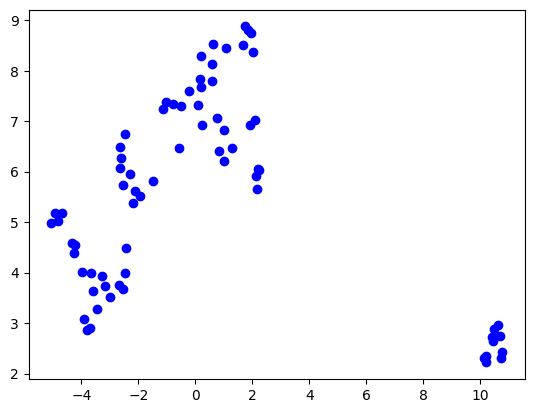

In [26]:
import matplotlib.pyplot as plt

plt.scatter(x, y, c ="blue")
plt.show()